In [1]:
import pandas as pd

In [2]:
import re 

def sorted_nicely( l ): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

In [3]:
import pandas as pd
import h5py
import logging
import numpy as np

import pandas as pd
from scipy import stats, sparse
import bottleneck
#%matplotlib notebook
%matplotlib inline
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

from scipy.sparse import csr_matrix

from scipy import sparse
#import pickle
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.sparse import csr_matrix

In [32]:
def run_egad(go, nw, **kwargs):
    """EGAD running function
    
    Wrapper to lower level functions for EGAD

    EGAD measures modularity of gene lists in co-expression networks. 

    This was translated from the MATLAB version, which does tiled Cross Validation
    
    The useful kwargs are:
    int - nFold : Number of CV folds to do, default is 3, 
    int - {min,max}_count : limits for number of terms in each gene list, these are exclusive values


    Arguments:
        go {pd.DataFrame} -- dataframe of genes x terms of values [0,1], where 1 is included in gene lists
        nw {pd.DataFrame} -- dataframe of co-expression network, genes x genes
        **kwargs 
    
    Returns:
        pd.DataFrame -- dataframe of terms x metrics where the metrics are 
        ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    """
    assert nw.shape[0] == nw.shape[1] , 'Network is not square'
    #print(nw.index)
    #nw.columns = nw.columns.astype(int)
    #print(nw.columns.astype(int))
    assert np.all(nw.index == nw.columns) , 'Network index and columns are not in the same order'

    #nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    #nw = nw.loc[nw_mask, nw_mask].astype('float')
    #np.fill_diagonal(nw.values, 1)
    return _runNV(go, nw, **kwargs)

def _runNV(go, nw, nFold=3, min_count=1, max_count=1807):

    #Make sure genes are same in go and nw
    #go.index = go.index.map(str) 
    #nw.index = nw.index.map(str)
    #nw.index = nw.index.str.replace('_', '')
    #go.index = go.index.str.replace('_', '')
    print (nw)
    genes_intersect = go.index.intersection(nw.index)


    print (genes_intersect)
    go = go.loc[genes_intersect, :]
    nw = nw.loc[genes_intersect, genes_intersect]
    print (go)
    print (nw.shape)
    print (go.shape)
    sparsity = 1.0 - np.count_nonzero(go) / go.size
    print (sparsity)
    sparsity = 1.0 - np.count_nonzero(nw) / nw.size
    print (sparsity)
    #print(nw
    #print(go
    nw_mask = nw.isna().sum(axis=1) != nw.shape[1]
    nw = nw.loc[nw_mask, nw_mask].astype('float')
    np.fill_diagonal(nw.values, 1)
    #Make sure there aren't duplicates
    duplicates = nw.index.duplicated(keep='first')
    nw = nw.loc[~duplicates, ~duplicates]

    go = go.loc[:, (go.sum(axis=0) > min_count) & (go.sum(axis=0) < max_count)]
    go = go.loc[~go.index.duplicated(keep='first'), :]
    print(go.sum(axis=0))

    roc = _new_egad(go.values, nw.values, nFold)

    col_names = ['AUC', 'AVG_NODE_DEGREE', 'DEGREE_NULL_AUC', 'P_Value']
    #Put output in dataframe
    return pd.DataFrame(dict(zip(col_names, roc)), index=go.columns)

def _new_egad(go, nw, nFold):

    #Build Cross validated Positive
    x, y = np.where(go)
    #print(x, y)
    cvgo = {}
    for i in np.arange(nFold):
        a = x[i::nFold]
        #print(a)
        b = y[i::nFold]
        dat = np.ones_like(a)
        mask = sparse.coo_matrix((dat, (a, b)), shape=go.shape)
        cvgo[i] = go - mask.toarray()

    CVgo = np.concatenate(list(cvgo.values()), axis=1)
    #print(CVgo)

    sumin = np.matmul(nw.T, CVgo)

    degree = np.sum(nw, axis=0)
    #print(degree)
    #print(degree[:, None])

    predicts = sumin / degree[:, None]
    #print(predicts)

    np.place(predicts, CVgo > 0, np.nan)

    #print(predicts)

    #Calculate ranks of positives
    rank_abs = lambda x: stats.rankdata(np.abs(x))
    predicts2 = np.apply_along_axis(rank_abs, 0, predicts)
    #print(predicts2)

    #Masking Nans that were ranked (how tiedrank works in matlab)
    predicts2[np.isnan(predicts)] = np.nan
    #print(predicts2)

    filtering = np.tile(go, nFold)
    #print(filtering)

    #negatives :filtering == 0
    #Sets Ranks of negatives to 0
    np.place(predicts2, filtering == 0, 0)

    #Sum of ranks for each prediction
    p = bottleneck.nansum(predicts2, axis=0)
    n_p = np.sum(filtering, axis=0) - np.sum(CVgo, axis=0)

    #Number of negatives
    #Number of GO terms - number of postiive
    n_n = filtering.shape[0] - np.sum(filtering, axis=0)

    roc = (p / n_p - (n_p + 1) / 2) / n_n
    U = roc * n_p * n_n
    Z = (np.abs(U - (n_p * n_n / 2))) / np.sqrt(n_p * n_n *
                                                (n_p + n_n + 1) / 12)
    roc = roc.reshape(nFold, go.shape[1])
    Z = Z.reshape(nFold, go.shape[1])
    #Stouffer Z method
    Z = bottleneck.nansum(Z, axis=0) / np.sqrt(nFold)
    #Calc ROC of Neighbor Voting
    roc = bottleneck.nanmean(roc, axis=0)
    P = stats.norm.sf(Z)

    #Average degree for nodes in each go term
    avg_degree = degree.dot(go) / np.sum(go, axis=0)

    #Calc null auc for degree
    ranks = np.tile(stats.rankdata(degree), (go.shape[1], 1)).T

    np.place(ranks, go == 0, 0)

    n_p = bottleneck.nansum(go, axis=0)
    nn = go.shape[0] - n_p
    p = bottleneck.nansum(ranks, axis=0)

    roc_null = (p / n_p - ((n_p + 1) / 2)) / nn
    #print(roc)
    return roc, avg_degree, roc_null, P


#reads the go_prop file
#pickle_in = open('gotermindex.pickle','rb')

In [216]:
from scipy.sparse import coo_matrix
#Data handling
import h5py

import logging
#Mathematical libraries
import numpy as np

import pandas as pd

%matplotlib inline

import bottleneck

import matplotlib.pyplot as plt
#df_go_id_enseml = pd.read_csv('/data/johlee/geneIDConversions/9606_gene_info.tab', sep='\t') #this file has a lot of mapping, EntrezID, uniprot, Ensembl ID, genename
#df_go_id_enseml.dropna(subset=['EnsemblID'])
#mydict_EID_UID = dict(zip(df_go_id_enseml.EnsemblID, df_go_id_enseml.UniProtID))
def parse_go_hd5(filename):
    """
    Loads data in file to dataframe.
    """
    with h5py.File(filename, 'r') as f:
        col_uid = []
        logging.debug("reading matrix...")
        row = [ s.decode() for s in  f['GO'][:] ]
        columns = [ s.decode() for s in  f['genes'][:] ]
        matrix = f['ind'][:] - 1 #the indices in this matrix are stored from 1 
        coo = coo_matrix(( np.ones(1901323) , (matrix[0,:],matrix[1,:] )), shape=(len(columns), len(row)) )
        logging.debug("reading columns. converting to unicode")
        for x in columns:
            try:
                col_uid.append(x)
            except KeyError:
                print (x)
                col_uid.append('del')
        #col_uid = [mydict_EID_UID[x] for x in columns]
        logging.debug("making dataframe...")

        print (coo.toarray().shape)
        df = pd.DataFrame(coo.toarray(),  index=col_uid, columns = row )
    return df


In [217]:
go_df = parse_go_hd5("/data/johlee/CoCoCoNet/gene2go/human_gene2go.hdf5")
duplicates = go_df.index.duplicated(keep='first')
go_df = go_df.loc[~duplicates, :]

(19016, 22517)


In [12]:
from lohia_utilities.load_lee_matrix import parse_expression_hd5_lee
exp_file = parse_expression_hd5_lee("/data/johlee/CoCoCoNet/networks/human_prioAggNet.hdf5")

In [26]:
exp_file

ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000276345         0.085152         0.055478         0.092469   
ENSG00000277856         0.025113         0.045883         0.077274   
ENSG00000275063         0.005367         0.013963         0.031017   
ENSG00000278817         0.458116         0.154940         0.374283   
ENSG00000277196         0.389884         0.049407         0.242737   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750         0.809451         0.673940         0.028341   
ENSG00000268903         0.946427         0.811533         0.065573   
ENSG00000269981         1.000000         0.833857         0.110389   
ENSG00000241860         0.833857         1.000000         0.083856   
...                          ...              ...              ...   
ENSG00000276345         0.101842         0.018642         0.001793   
ENSG00000277856         0.079891         0.034978         0.067405   
ENSG00000275063         0.014742         0.019394         0.019134   
ENSG00000278817         0.169647         0.278851         0.255696   
ENSG00000277196         0.230788         0.139266         0.257408   

                 ENSG00000279457  ENSG00000228463  ENSG00000237094  \
ENSG00000278267         0.896050         0.229694         0.550274   
ENSG00000233750         0.463029         0.399338         0.764022   
ENSG00000268903         0.767021         0.441015         0.856639   
ENSG00000269981         0.656542         0.527122         0.903084   
ENSG00000241860         0.508489         0.340035         0.944649   
...                          ...              ...              ...   
ENSG00000276345         0.261986         0.020327         0.091009   
ENSG00000277856         0.140386         0.012266         0.094181   
ENSG00000275063         0.067660         0.011989         0.042390   
ENSG00000278817         0.762126         0.355218         0.176952   
ENSG00000277196         0.619342         0.117430         0.171613   

                 ENSG00000225972  ...  ENSG00000275594  ENSG00000276497  \
ENSG00000278267         0.208983  ...         0.089306         0.275199   
ENSG00000233750         0.018238  ...         0.042306         0.004487   
ENSG00000268903         0.194718  ...         0.019009         0.025281   
ENSG00000269981         0.067739  ...         0.069903         0.070774   
ENSG00000241860         0.002976  ...         0.208856         0.125405   
...                          ...  ...              ...              ...   
ENSG00000276345         0.017107  ...         0.007437         0.026895   
ENSG00000277856         0.032696  ...         0.003437         0.000490   
ENSG00000275063         0.051837  ...         0.005523         0.000559   
ENSG00000278817         0.365041  ...         0.063697         0.229018   
ENSG00000277196         0.250084  ...         0.012124         0.167913   

                 ENSG00000273850  ENSG00000271254  ENSG00000275405  \
ENSG00000278267         0.708864         0.491642         0.013446   
ENSG00000233750         0.202850         0.146670         0.028417   
ENSG00000268903         0.510202         0.078068         0.015855   
ENSG00000269981         0.478497         0.264099         0.021557   
ENSG00000241860         0.327995         0.624400         0.257520   
...                          ...              ...              ...   
ENSG00000276345         0.174295         0.115015         0.018660   
ENSG00000277856         0.095768 

In [21]:
df_2_or = pd.read_csv('/data/lohia/gene_distance_expresseion/gene_contact_map_rao/processed_hi_c_files_one_buffer/chr1_tss_tss_100.csv')
df_2_or.set_index('Gene stable ID', inplace=True)

In [22]:
df_2_or

ENSG00000227232  ENSG00000223972  ENSG00000237613  \
Gene stable ID                                                       
ENSG00000227232                0               26               26   
ENSG00000223972               26                0               26   
ENSG00000237613               26               26                0   
ENSG00000186092               26               26               26   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137              207              207              207   
ENSG00000264500              207              207              207   
ENSG00000171161              207              207              207   
ENSG00000171163              207              207              207   
ENSG00000185220             1815             1815             1815   

                 ENSG00000186092  ENSG00000235249  ENSG00000185097  \
Gene stable ID                                                       
ENSG00000227232               26                0             1011   
ENSG00000223972               26                0             1011   
ENSG00000237613               26                0             1011   
ENSG00000186092                0                0             1011   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137              207                0              192   
ENSG00000264500              207                0              192   
ENSG00000171161              207                0              192   
ENSG00000171163              207                0              192   
ENSG00000185220             1815                0              291   

                 ENSG00000228327  ENSG00000228794  ENSG00000230368  \
Gene stable ID                                                       
ENSG00000227232              379              379              208   
ENSG00000223972              379              379              208   
ENSG00000237613              379              379              208   
ENSG00000186092              379              379              208   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137              136              136               74   
ENSG00000264500              136              136               74   
ENSG00000171161              136              136               74   
ENSG00000171163              136              136               74   
ENSG00000185220              161              161               96   

                 ENSG00000230699  ...  ENSG00000177151  ENSG00000187701  \
Gene stable ID                    ...                                     
ENSG00000227232              208  ...               29               29   
ENSG00000223972              208  ...               29               29   
ENSG00000237613              208  ...               29               29   
ENSG00000186092              208  ...               29               29   
ENSG00000235249                0  ...                0                0   
...                          ...  ...              ...              ...   
ENSG00000175137               74  ...             4900             4900   
ENSG00000264500               74  ...             4900             4900   
ENSG00000171161               74  ...             4900             4900   
ENSG00000171163               74  ...             4900             4900   
ENSG00000185220               96  ...             3769             3769   

                 ENSG00000189181  ENSG00000232694  ENSG00000266949  \
Gene stable ID                                                       
ENSG00000227232               29               29               47   
ENSG00000223972               29               29               47   
ENSG00000237613             

In [19]:
df_2_or = np.where(df_2_or >=3, 1, 0)

In [23]:
array = np.where(df_2_or >=3, 1, 0)

In [24]:
dataframe=pd.DataFrame(array, columns=df_2_or.columns , index=df_2_or.index ) 

In [25]:
dataframe

ENSG00000227232  ENSG00000223972  ENSG00000237613  \
Gene stable ID                                                       
ENSG00000227232                0                1                1   
ENSG00000223972                1                0                1   
ENSG00000237613                1                1                0   
ENSG00000186092                1                1                1   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137                1                1                1   
ENSG00000264500                1                1                1   
ENSG00000171161                1                1                1   
ENSG00000171163                1                1                1   
ENSG00000185220                1                1                1   

                 ENSG00000186092  ENSG00000235249  ENSG00000185097  \
Gene stable ID                                                       
ENSG00000227232                1                0                1   
ENSG00000223972                1                0                1   
ENSG00000237613                1                0                1   
ENSG00000186092                0                0                1   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137                1                0                1   
ENSG00000264500                1                0                1   
ENSG00000171161                1                0                1   
ENSG00000171163                1                0                1   
ENSG00000185220                1                0                1   

                 ENSG00000228327  ENSG00000228794  ENSG00000230368  \
Gene stable ID                                                       
ENSG00000227232                1                1                1   
ENSG00000223972                1                1                1   
ENSG00000237613                1                1                1   
ENSG00000186092                1                1                1   
ENSG00000235249                0                0                0   
...                          ...              ...              ...   
ENSG00000175137                1                1                1   
ENSG00000264500                1                1                1   
ENSG00000171161                1                1                1   
ENSG00000171163                1                1                1   
ENSG00000185220                1                1                1   

                 ENSG00000230699  ...  ENSG00000177151  ENSG00000187701  \
Gene stable ID                    ...                                     
ENSG00000227232                1  ...                1                1   
ENSG00000223972                1  ...                1                1   
ENSG00000237613                1  ...                1                1   
ENSG00000186092                1  ...                1                1   
ENSG00000235249                0  ...                0                0   
...                          ...  ...              ...              ...   
ENSG00000175137                1  ...                1                1   
ENSG00000264500                1  ...                1                1   
ENSG00000171161                1  ...                1                1   
ENSG00000171163                1  ...                1                1   
ENSG00000185220                1  ...                1                1   

                 ENSG00000189181  ENSG00000232694  ENSG00000266949  \
Gene stable ID                                                       
ENSG00000227232                1                1                1   
ENSG00000223972                1                1                1   
ENSG00000237613             

                 ENSG00000278267  ENSG00000233750  ENSG00000268903  \
ENSG00000278267         1.000000         0.343890         0.487717   
ENSG00000233750         0.343890         1.000000         0.860658   
ENSG00000268903         0.487717         0.860658         1.000000   
ENSG00000269981         0.504516         0.809451         0.946427   
ENSG00000241860         0.479969         0.673940         0.811533   
...                          ...              ...              ...   
ENSG00000276345         0.085152         0.055478         0.092469   
ENSG00000277856         0.025113         0.045883         0.077274   
ENSG00000275063         0.005367         0.013963         0.031017   
ENSG00000278817         0.458116         0.154940         0.374283   
ENSG00000277196         0.389884         0.049407         0.242737   

                 ENSG00000269981  ENSG00000241860  ENSG00000279928  \
ENSG00000278267         0.504516         0.479969         0.343116   
ENSG00000233750    

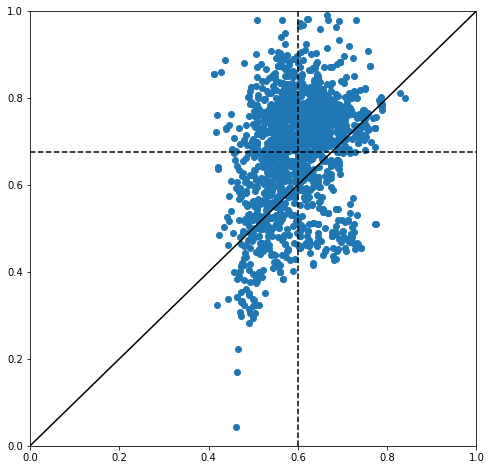

In [33]:
df = run_egad(dataframe, exp_file)
#df_0 = run_egad(go, nw_0)
print(df)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8), sharey=True)
#ax = df.plot.scatter(x='AUC',y='DEGREE_NULL_AUC')
ax.scatter(x=df['AUC'].values,y=df['DEGREE_NULL_AUC'].values)
#ax = df.plot('AUC', 'DEGREE_NULL_AUC', kind='scatter', ax=ax)
#df['go_an'] = df.index
#df[['AUC','DEGREE_NULL_AUC','go_an']].apply(lambda row: ax.text(*row),axis=1)
#print df.mean()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.plot([0, 1], [0, 1], transform=ax.transAxes, c='black')
plt.axvline(x=df['AUC'].mean(),c='black',ls='--')
plt.axhline(y=df['DEGREE_NULL_AUC'].mean(), c='black', ls='--')
print(df['AUC'].mean())
#print(df_0['AUC'].mean())
print (df['AUC'].idxmax())
#plt.show()
plt.savefig('%s.pdf' %0, bbox_inches='tight', dpi=100)

In [210]:
df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/X_dist_with_georg_hic_sub_median_hic_500.h5')

In [211]:
df_2_or

tss_tss       exp  exp_georg  hi-c-rao strand_x  gene_order_tss_x  \
0               0  1.000000   0.851248       0.0        +              1013   
1        48500772  0.194329        NaN       NaN        -              1693   
2        14644244  0.912021        NaN    2119.0        -               891   
3        22650500  0.964389        NaN    1966.0        -               598   
4        13404206  0.989904        NaN    2345.0        +               905   
...           ...       ...        ...       ...      ...               ...   
597524   30681475  0.903413        NaN       NaN        +              2358   
597525    5020185  0.513123        NaN    4116.0        +              1698   
597526  103592204  0.985573   0.701583     270.0        -               254   
597527    8359757  0.973737   0.705286    3663.0        -              1913   
597528          0  1.000000   0.851248       0.0        +              1809   

        gene_order_tes_x Gene stable ID_x     Gene type_x Uniprot_dc_x  ...  \
0                   1015  ENSG00000089289  protein_coding       P78318  ...   
1                   1692  ENSG00000230399             NaN          NaN  ...   
2                    891  ENSG00000247746  protein_coding       Q70EK9  ...   
3                    597  ENSG00000147124  protein_coding       P51814  ...   
4                    907  ENSG00000204272  protein_coding   A0A0U1RRE5  ...   
...                  ...              ...             ...          ...  ...   
597524              2359  ENSG00000269335  protein_coding       Q9Y6K9  ...   
597525              1699  ENSG00000203650             NaN          NaN  ...   
597526               254  ENSG00000177189  protein_coding       P51812  ...   
597527              1912  ENSG00000123728  protein_coding       Q9Y3L5  ...   
597528              1812  ENSG00000101966  protein_coding       P98170  ...   

        chrom_x  strand_y gene_order_tss_y gene_order_tes_y  Gene stable ID_y  \
0          chrX         +             1013             1015   ENSG00000089289   
1          chrX         +             1013             1015   ENSG00000089289   
2          chrX         +             1013             1015   ENSG00000089289   
3          chrX         +             1013             1015   ENSG00000089289   
4          chrX         +             1013             1015   ENSG00000089289   
...         ...       ...              ...              ...               ...   
597524     chrX         +             1809             1812   ENSG00000101966   
597525     chrX         +             1809             1812   ENSG00000101966   
597526     chrX         +             1809             1812   ENSG00000101966   
597527     chrX         +             1809             1812   ENSG00000101966   
597528     chrX         +             1809             1812   ENSG00000101966   

           Gene type_y Uniprot_dc_y      dc_y seq_length_y  chrom_y  
0       protein_coding       P78318  0.218289        339.0     chrX  
1       protein_coding       P78318  0.218289        339.0     chrX  
2       protein_coding       P78318  0.218289        339.0     chrX  
3       protein_coding       P78318  0.218289        339.0     chrX  
4       protein_coding       P78318  0.218289        339.0     chrX  
...                ...          ...       ...          ...      ...  
597524  protein_coding       P98170  0.000000        497.0     chrX  
597525  protein_coding       P98170  0.000000        497.0     chrX  
597526  protein_coding       P98170  0.000000        497.0     chrX  
597527  protein_coding       P98170  0.000000        497.0     chrX  
597528  protein_coding       P98170  0.000000        497.0     chrX  

[597529 rows x 22 columns]

In [499]:
df_2_or = df_2_or[df_2_or['exp_georg'] >= 0] 

0.0
gene_order_tss_y
35      35735.0
36      35735.0
39      35735.0
40      35735.0
42      10093.0
         ...   
2393    16489.0
2395    16489.0
2399    39399.0
2408    39399.0
2410    39399.0
Length: 597, dtype: float64


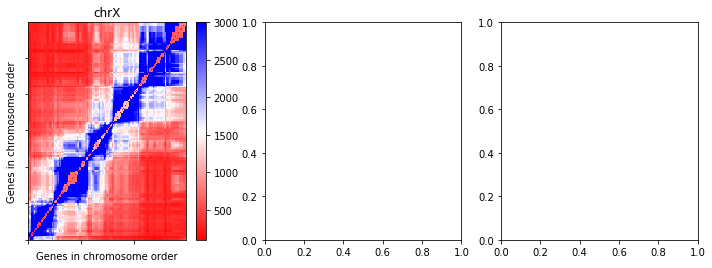

In [183]:
plots_with_1_level_3d(df_chr, 'hi-c-rao')

0.0
gene_order_tss_y
35      0.999161
36      0.999161
39      0.999161
40      0.999161
42      0.999161
          ...   
2393    0.999161
2395    0.999161
2399    0.999161
2408    0.999161
2410    0.999161
Length: 597, dtype: float64


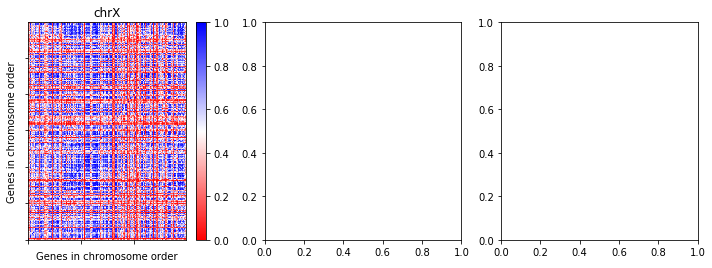

In [168]:
from lohia_utilities.create_corr_network import rank
df_chr = df_chr[df_chr['hi-c-rao'] >= 0] 
ranked_matirx = rank(df_chr['exp'])
df_chr['exp'] = ranked_matirx
plots_with_1_level_3d(df_chr,'exp')

0.0
gene_order_tss_y
35      0.402076
36      0.402076
39      0.454589
40      0.454589
42      0.454589
          ...   
2393    0.994606
2395    0.994606
2399    0.994606
2408    0.994606
2410    0.994606
Length: 597, dtype: float64


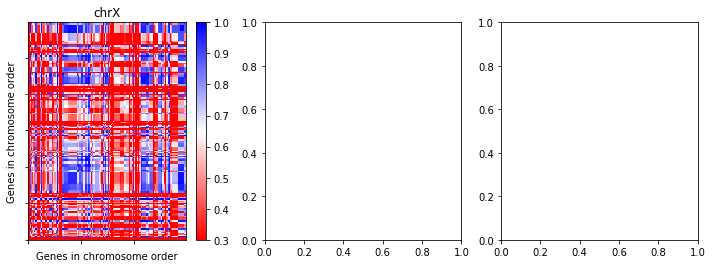

In [195]:
from lohia_utilities.create_corr_network import rank
df_chr = df_chr[df_chr['hi-c-rao'] >= 0] 
ranked_matirx = rank(df_chr['exp_mean'])
df_chr['exp_mean'] = ranked_matirx
plots_with_1_level_3d(df_chr,'exp_mean')

0.0
gene_order_tss_y
6       0.999501
9       0.999501
11      0.999501
12      0.999501
14      0.999501
          ...   
3345    0.999501
3347    0.999501
3348    0.999501
3349    0.999501
3355    0.999501
Length: 1004, dtype: float64


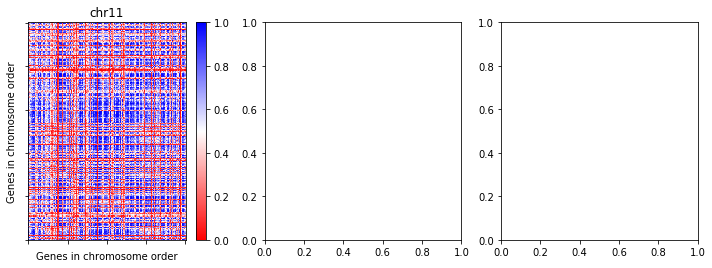

In [63]:
from lohia_utilities.create_corr_network import rank
df_2_or_2 = df_2_or_2[df_2_or_2['hi-c-rao'] >= 0] 
ranked_matirx = rank(df_2_or_2['exp'])
df_2_or_2['exp'] = ranked_matirx
plots_with_1_level_3d(df_2_or_2,'exp')

0.0
gene_order_tss_y
6       0.883556
9       0.883556
11      0.883556
12      0.883556
14      0.883556
          ...   
3345    0.943445
3347    0.943445
3348    0.943445
3349    0.943445
3355    0.943445
Length: 1293, dtype: float64


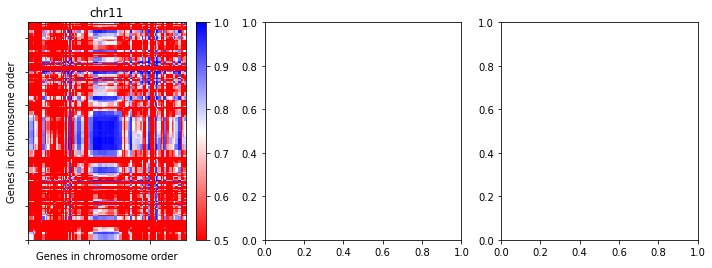

In [592]:
ranked_matirx = rank(df_2_or['exp_median'])
df_2_or['exp_median'] = ranked_matirx
plots_with_1_level_3d(df_2_or,'exp_median')

In [160]:
resoultion=500

In [198]:
df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/11_dist_with_georg_hic_sub_median_hic_%s.h5' %resoultion)

In [162]:
df_2_or = df_2_or[['tss_tss', 'exp', 'hi-c-rao', 'Gene stable ID_x', 'Gene stable ID_y', 'chrom_x', 'gene_order_tss_x', 'gene_order_tss_y']]
df_2_or = df_2_or[df_2_or['hi-c-rao'] >= 0] 
df_2_or['hi-c-rao'].isnull().astype(int).sum() / df_2_or.shape[0]

0.0

In [163]:
change_group_level_1 = df_2_or.groupby(['chrom_x'])
for chrm in change_group_level_1.groups.keys():
    df_chr = change_group_level_1.get_group(chrm)
    df_chr['pairs'] = [x+"_"+y for x,y in zip(df_chr['Gene stable ID_y'], df_chr['Gene stable ID_x'])]
    df_chr.set_index('pairs', inplace=True)
    unique_genes = list(set(df_chr['Gene stable ID_x'].unique()))
    print (len(unique_genes))
    gene_resolution_pairs= {}
    for each_gene in  unique_genes:
        gene_resolution_pairs[each_gene] = df_chr[(df_chr['Gene stable ID_x'] == each_gene) & (df_chr['tss_tss'] <=resoultion * 1000)]['Gene stable ID_y'].to_list()
    counter = 0
    for pairs in itertools.combinations(unique_genes, 2):
        index_list = [r[0]+ '_' + r[1] for r in itertools.product(gene_resolution_pairs[pairs[0]], gene_resolution_pairs[pairs[1]])]
        df_chr.at[index_list, 'exp_median'] = df_chr.loc[index_list,:]['exp'].median()
        df_chr.at[index_list, 'exp_mean'] = df_chr.loc[index_list,:]['exp'].mean()
        index_list = [r[0]+ '_' + r[1] for r in itertools.product(gene_resolution_pairs[pairs[1]], gene_resolution_pairs[pairs[0]])] 
        df_chr.at[index_list, 'exp_mean'] = df_chr.loc[index_list,:]['exp'].mean()
        df_chr.at[index_list, 'exp_median'] = df_chr.loc[index_list,:]['exp'].median()

597


In [189]:
df_2_or

tss_tss       exp  hi-c-rao Gene stable ID_x Gene stable ID_y  \
0               0  0.999161       0.0  ENSG00000101868  ENSG00000101868   
4        15885463  0.794246    1278.0  ENSG00000182220  ENSG00000101868   
5       129717615  0.745656     282.0  ENSG00000102125  ENSG00000101868   
6        40340805  0.928513     987.0  ENSG00000126970  ENSG00000101868   
7        68980104  0.263513     694.0  ENSG00000179083  ENSG00000101868   
...           ...       ...       ...              ...              ...   
597524   37279597  0.398370    1065.0  ENSG00000158427  ENSG00000131080   
597525    8728478  0.641730    3344.0  ENSG00000198205  ENSG00000131080   
597526   19056891  0.424817    1580.0  ENSG00000102265  ENSG00000131080   
597527    5271519  0.441382    2781.0  ENSG00000204131  ENSG00000131080   
597528          0  0.999161       0.0  ENSG00000131080  ENSG00000131080   

       chrom_x  gene_order_tss_x  gene_order_tss_y  
0         chrX               308               308  
4         chrX               476               308  
5         chrX              2344               308  
6         chrX               950               308  
7         chrX              1331               308  
...        ...               ...               ...  
597524    chrX              1507               976  
597525    chrX               920               976  
597526    chrX               602               976  
597527    chrX              1079               976  
597528    chrX               976               976  

[356409 rows x 8 columns]

In [190]:
df_chr['exp_mean'].fillna(1, inplace=True)

In [145]:
df =  df.join(long_form[[col_name]], how='left')

tss_tss       exp  hi-c-rao  \
pairs                                                            
ENSG00000101868_ENSG00000101868          0  1.000000       0.0   
ENSG00000101868_ENSG00000182220   15885463  0.893384    1278.0   
ENSG00000101868_ENSG00000102125  129717615  0.864865     282.0   
ENSG00000101868_ENSG00000126970   40340805  0.963447     987.0   
ENSG00000101868_ENSG00000179083   68980104  0.423822     694.0   
...                                    ...       ...       ...   
ENSG00000131080_ENSG00000158427   37279597  0.574872    1065.0   
ENSG00000131080_ENSG00000198205    8728478  0.794596    3344.0   
ENSG00000131080_ENSG00000102265   19056891  0.601445    1580.0   
ENSG00000131080_ENSG00000204131    5271519  0.617975    2781.0   
ENSG00000131080_ENSG00000131080          0  1.000000       0.0   

                                Gene stable ID_x Gene stable ID_y chrom_x  \
pairs                                                                       
ENSG00000101868_ENSG00000101868  ENSG00000101868  ENSG00000101868    chrX   
ENSG00000101868_ENSG00000182220  ENSG00000182220  ENSG00000101868    chrX   
ENSG00000101868_ENSG00000102125  ENSG00000102125  ENSG00000101868    chrX   
ENSG00000101868_ENSG00000126970  ENSG00000126970  ENSG00000101868    chrX   
ENSG00000101868_ENSG00000179083  ENSG00000179083  ENSG00000101868    chrX   
...                                          ...              ...     ...   
ENSG00000131080_ENSG00000158427  ENSG00000158427  ENSG00000131080    chrX   
ENSG00000131080_ENSG00000198205  ENSG00000198205  ENSG00000131080    chrX   
ENSG00000131080_ENSG00000102265  ENSG00000102265  ENSG00000131080    chrX   
ENSG00000131080_ENSG00000204131  ENSG00000204131  ENSG00000131080    chrX   
ENSG00000131080_ENSG00000131080  ENSG00000131080  ENSG00000131080    chrX   

                                 exp_mean  
pairs                                      
ENSG00000101868_ENSG00000101868  0.605398  
ENSG00000101868_ENSG00000182220  0.704656  
ENSG00000101868_ENSG00000102125  0.625642  
ENSG00000101868_ENSG00000126970  0.702912  
ENSG00000101868_ENSG00000179083  0.425180  
...                                   ...  
ENSG00000131080_ENSG00000158427  0.566538  
ENSG00000131080_ENSG00000198205  0.567519  
ENSG00000131080_ENSG00000102265  0.581551  
ENSG00000131080_ENSG00000204131  0.583395  
ENSG00000131080_ENSG00000131080  0.767078  

[356409 rows x 7 columns]

In [199]:
df_2_or_u = df_2_or[df_2_or['Gene stable ID_x'] != df_2_or['Gene stable ID_y']]

(0, 500)

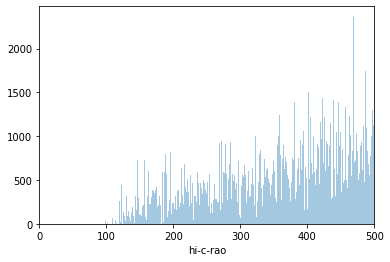

In [205]:
import seaborn as sns
ax = sns.distplot(df_2_or_u['hi-c-rao'], bins=10000, hist=True, kde=False, hist_kws={"range":(1, 10000)})
#ax.set_ylim(0, 500)
ax.set_xlim(0, 500)

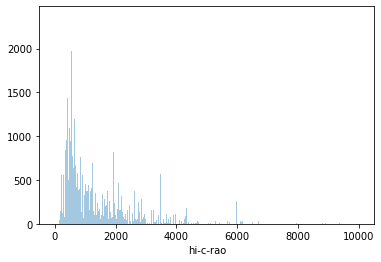

In [209]:
import seaborn as sns
ax = sns.distplot(df_2_or_u['hi-c-rao'], bins=10000, hist=True, kde=False, hist_kws={"range":(1, 10000)})
#ax.set_ylim(0, 1500)
#ax.set_xlim(0, 500)

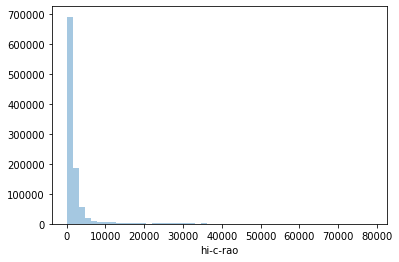

In [201]:
import seaborn as sns
ax = sns.distplot(df_2_or_u['hi-c-rao'], hist=True, kde=False)
#ax.set_ylim(0, 500)
#ax.set_xlim(0, 500)

(0, 10000)

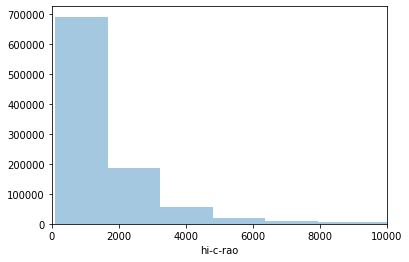

In [204]:
import seaborn as sns
ax = sns.distplot(df_2_or_u['hi-c-rao'], hist=True, kde=False)
#ax.set_ylim(0, 500)
ax.set_xlim(0, 10000)

In [600]:
# import numpy as np
import pandas as pd
import warnings
from lohia_utilities.calculate_auc import *
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from lohia_utilities.create_corr_network import rank

#df_2_or = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/11_dist_with_georg_hic_sub_median_hic_500.h5')

#df_2_or = df_2_or[df_2_or['exp_georg'] >= 0] # liming the matrix to only chosen values for rank standerization
#df_2_or = df_2_or[df_2_or['hi-c-rao'] >= 0] # liming the matrix to only chosen values for rank standerization
df_2_or_u = df_2_or[df_2_or['Gene stable ID_x'] != df_2_or['Gene stable ID_y']]
#ranked_matirx = rank(df_2_or['exp_georg'])
#df_2_or['exp_georg'] = ranked_matirx
#df_2_or.rename(columns={"exp_georg": "exp (GK)"}, inplace=True)

ranked_matirx = rank(df_2_or['exp'])
df_2_or['exp'] = ranked_matirx

#ranked_matirx = rank(df_2_or['hi-c-rao'])
#df_2_or['hi-c-rao'] = ranked_matirx
m_l = []
change_group_level_1 = df_2_or.groupby(['chrom_x'])
for chrm in change_group_level_1.groups.keys():
    df = change_group_level_1.get_group(chrm)
    num_pairs = df['Gene stable ID_x'].nunique()

    prot_list_sp = np.array_split(df, num_pairs, axis=0)
    for i in range(0,num_pairs):

        long_form_top = prot_list_sp[int(i)]
        long_form_top['dist'] = long_form_top['hi-c-rao']
        long_form_top = long_form_top[long_form_top['tss_tss'] >= 10000000] # liming the matrix to only chosen values for rank standerization

        long_form_top = long_form_top[long_form_top['Gene stable ID_x'] != long_form_top['Gene stable ID_y']] # remove all the self pairs from each set
        long_form_top['hi-c-rao'].fillna(-1, inplace=True)
        mp =  long_form_top['Gene stable ID_y'].values[0]
        #print (long_form_top.shape)
        
        exp_median = long_form_top['exp'].median()
        exp_mean = long_form_top['exp'].mean()
        exp_var = long_form_top['exp'].var()

        long_form_top = long_form_top.reset_index()
        if long_form_top['exp'].values[0] >=0:
    
       

            for dist_thresh in [1,5,10,100,int(num_pairs/2),700]:
            #for dist_thresh in [100000,1000000,10000000,100000000]:
            #for dist_thresh in [4000]:
            #for dist_thresh in [df_2_or_u["hi-c-rao"].min(), df_2_or["hi-c-rao"].max()-1, df_2_or["hi-c-rao"].mean(), df_2_or["hi-c-rao"].median()]:
                #long_form_top["True_sim"] = [1 if score > dist_thresh else 0 for score in long_form_top["dist"]]  
                
                long_form_top = long_form_top.sort_values(by=['dist'], ascending=False) 
                long_form_top["True_sim"] = [0 if score > dist_thresh else 0 for score in long_form_top["dist"]]  
                for ind_val in long_form_top.index.values[0:dist_thresh]:
                    long_form_top.at[ind_val, 'True_sim'] = 1
                    
                #long_form_top = long_form_top.sort_values(by=['dist'], ascending=True) 
                #long_form_top["True_sim"] = [1 if score > dist_thresh else 1 for score in long_form_top["dist"]]  
                #for ind_val in long_form_top.index.values[0:dist_thresh]:
                #    long_form_top.at[ind_val, 'True_sim'] = 0
                #
                #long_form_top["True_sim"] = [1 if score <= dist_thresh else 0 for score in long_form_top["dist"]] 
                #long_form_top["True_sim"] = [1 if score >= dist_thresh else 1 if score2 <= 1000 else 0 for score, score2 in zip(long_form_top["dist"],long_form_top["tss_tss"])]    
                long_form_top["true_pos"] = [score for score in long_form_top["True_sim"]]
                long_form_top["true_neg"] = [1 if score==0 else 0 for score in long_form_top["True_sim"]]
                long_form_top["predicted_sim_from_exp"] = [score for score in long_form_top["exp_median"]]
                ca = calc_auroc (long_form_top,predicted_score='predicted_sim_from_exp')
                m_curve = calc_auc_curve (long_form_top,predicted_score='predicted_sim_from_exp')
                pr_curve = prec_recall (long_form_top,predicted_score='predicted_sim_from_exp')

                tpd = pd.DataFrame(m_curve)
                if m_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    m_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    m_curve  = {}
                tpd = pd.DataFrame(pr_curve)
                if pr_curve:
                    tpd[0] =  tpd[0].astype(float).round(2)
                    tpd = tpd.groupby([0]).mean()
                    pr_curve  = dict(zip(tpd.index, tpd[1]))
                else:
                    pr_curve  = {}
                m_l.append((chrm, num_pairs,dist_thresh, ca, m_curve, pr_curve, long_form_top["true_pos"].sum(), long_form_top["true_neg"].sum(), exp_median, exp_mean, exp_var, mp))
        else:
            pass

df_scores = pd.DataFrame(m_l, columns =['chrm', 'num_pairs','dist_thresh',  'auc', 'plot', 'pr_curve', 'true_pos', 'true_neg', 'exp_median', 'exp_mean', 'exp_var', 'Gene stable ID'])
df_scores.to_hdf('/data/lohia/gene_distance_expresseion/dist_files/chr11_100kb.h5', key='df', mode='w')    

/home/lohia/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['chrm', 'plot', 'pr_curve', 'Gene stable ID'], dtype='object')]

  encoding=encoding,


In [601]:
df_scores = pd.read_hdf('/data/lohia/gene_distance_expresseion/dist_files/chr11_100kb.h5')

In [493]:
df_scores

chrm  num_pairs  dist_thresh       auc  \
0     chr11       1004         4000       NaN   
1     chr11       1004         4000       NaN   
2     chr11       1004         4000       NaN   
3     chr11       1004         4000       NaN   
4     chr11       1004         4000  0.561063   
...     ...        ...          ...       ...   
999   chr11       1004         4000       NaN   
1000  chr11       1004         4000  0.820235   
1001  chr11       1004         4000       NaN   
1002  chr11       1004         4000  0.427163   
1003  chr11       1004         4000       NaN   

                                                   plot  \
0     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
2     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
3     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
4     {0.0: 0.0, 0.01: 0.0, 0.02: 0.0104166666666666...   
...                                                 ...   
999   {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1000  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.0, 0....   
1001  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   
1002  {0.0: 0.0, 0.01: 0.0, 0.02: 0.0, 0.03: 0.01739...   
1003  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....   

                                               pr_curve  true_pos  true_neg  \
0                                                    {}         0       650   
1                                                    {}         0       932   
2                                                    {}         0       647   
3                                                    {}         0       828   
4     {0.0: 0.0, 0.08: 0.021899579772188874, 0.17: 0...        12       696   
...                                                 ...       ...       ...   
999                                                  {}         0       896   
1000  {0.0: 0.0, 0.33: 0.011573465587966434, 0.67: 0...         3       738   
1001                                                 {}         0       646   
1002  {0.0: 0.0, 0.04: 0.03137291143578475, 0.09: 0....        23       913   
1003                                                 {}         0       647   

      exp_median  exp_mean   exp_var   Gene stable ID  
0       0.592583  0.547375  0.063044  ENSG00000174669  
1       0.732026  0.656574  0.070272  ENSG00000183340  
2       0.392391  0.379631  0.036577  ENSG00000182791  
3       0.822697  0.728352  0.067169  ENSG00000132275  
4       0.650224  0.608971  0.084299  ENSG00000168496  
...          ...       ...       ...              ...  
999     0.710174  0.617268  0.067416  ENSG00000151702  
1000    0.580503  0.522850  0.076284  ENSG00000156587  
1001    0.653405  0.605870  0.066594  ENSG00000173715  
1002    0.657461  0.592015  0.051981  ENSG00000166086  
1003    0.728689  0.649545  0.071352  ENSG00000239306  

[1004 rows x 12 columns]

In [595]:
df_scores[df_scores['dist_thresh'] == 4000]['auc'].isnull().astype(int).sum()

803

In [220]:
df_scores[df_scores['dist_thresh'] == 2000]

chrm  num_pairs  dist_thresh  auc  \
4     chr16        773         2000  NaN   
9     chr16        773         2000  NaN   
14    chr16        773         2000  NaN   
19    chr16        773         2000  NaN   
24    chr16        773         2000  NaN   
...     ...        ...          ...  ...   
3844  chr16        773         2000  NaN   
3849  chr16        773         2000  NaN   
3854  chr16        773         2000  NaN   
3859  chr16        773         2000  NaN   
3864  chr16        773         2000  NaN   

                                                   plot pr_curve  true_pos  \
4     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
9     {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
14    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
19    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
24    {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
...                                                 ...      ...       ...   
3844  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3849  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3854  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3859  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   
3864  {0.0: nan, 0.01: nan, 0.02: nan, 0.03: nan, 0....       {}         0   

      true_neg  exp_median  exp_mean   exp_var   Gene stable ID  
4          495    0.345003  0.322651  0.030117  ENSG00000245694  
9          496    0.619299  0.585025  0.087750  ENSG00000245694  
14         437    0.486055  0.477094  0.069154  ENSG00000198931  
19         420    0.554352  0.556762  0.077769  ENSG00000243716  
24         428    0.828832  0.726001  0.064853  ENSG00000168434  
...        ...         ...       ...       ...              ...  
3844       428    0.425241  0.405120  0.049482  ENSG00000260807  
3849       432    0.490119  0.454270  0.064232  ENSG00000169627  
3854       442    0.474922  0.465165  0.052825  ENSG00000248124  
3859       494    0.360949  0.368468  0.032043  ENSG00000102935  
3864       495    0.572479  0.551079  0.061528  ENSG00000177200  

[773 rows x 12 columns]

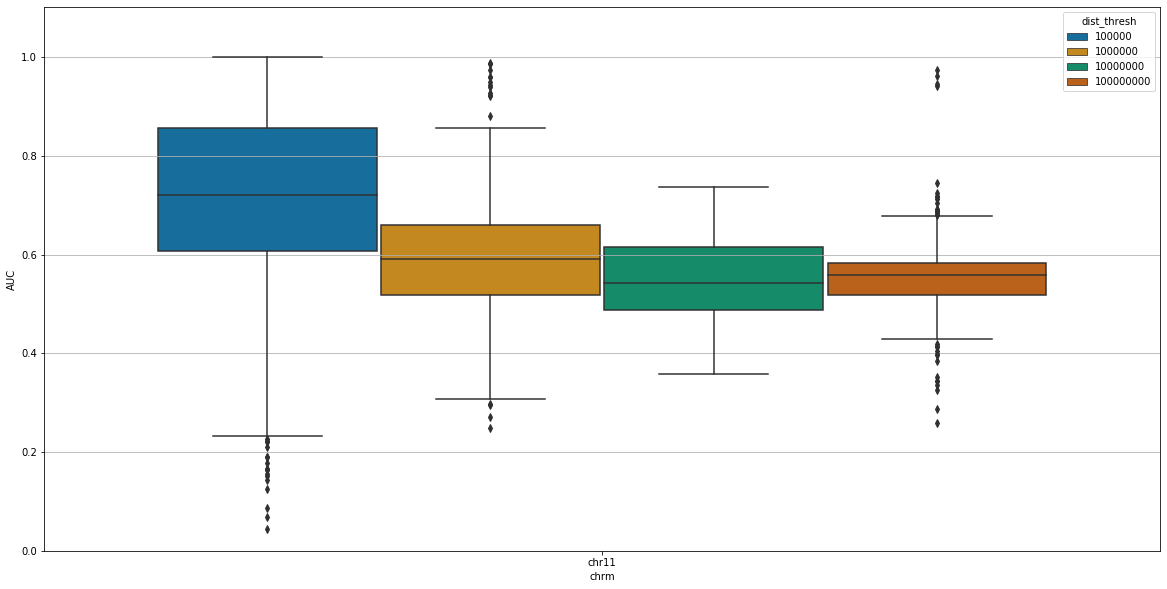

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

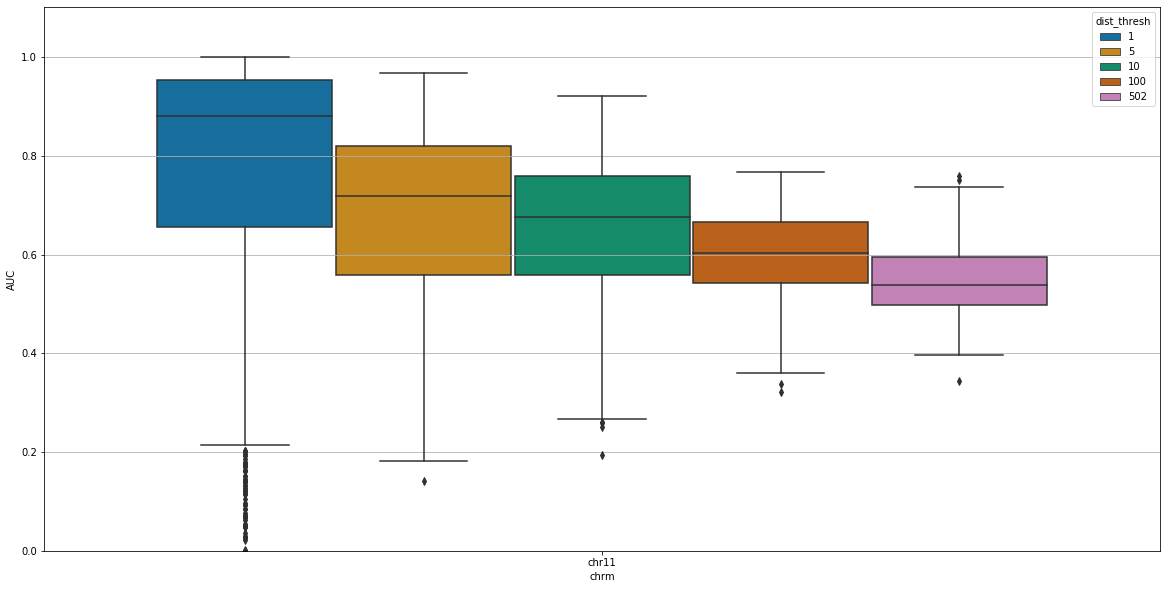

In [358]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

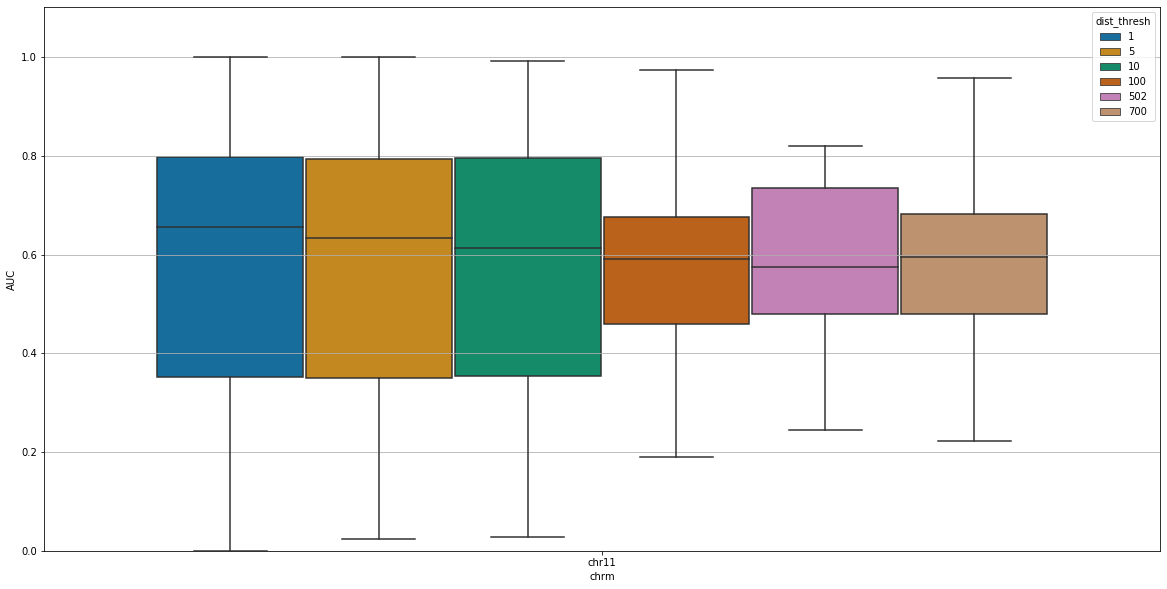

In [602]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

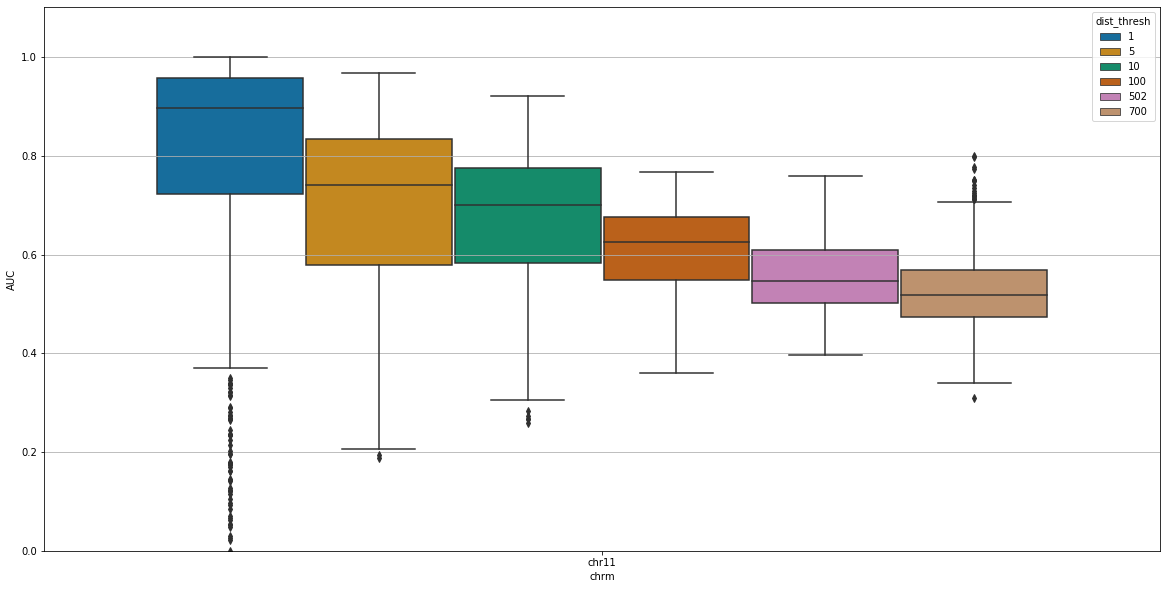

In [414]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind"
                 ,hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()

In [149]:
df_scores_plot = pd.concat([df_scores.drop(['plot'], axis=1), df_scores['plot'].apply(pd.Series)], axis=1)
df_plot = df_scores_plot.groupby(['chrm']).median()

In [143]:
df_scores['plot']

0       {0.0: 0.15891472868217105, 0.1: 0.358914728682...
1       {0.0: 0.19172932330827042, 0.1: 0.479591836734...
2       {0.0: 0.027435610302351626, 0.1: 0.14389697648...
3       {0.0: 0.03850267379679142, 0.1: 0.107486631016...
4       {0.0: 0.3575498575498566, 0.1: 0.7236467236467...
                              ...                        
999     {0.0: 0.0858757062146893, 0.1: 0.3598870056497...
1000    {0.0: 0.09021739130434761, 0.1: 0.192391304347...
1001    {0.0: 0.03621346886912323, 0.1: 0.156289707750...
1002    {0.0: 0.09125188536953226, 0.1: 0.208898944193...
1003    {0.0: 0.06352459016393448, 0.1: 0.174863387978...
Name: plot, Length: 1004, dtype: object

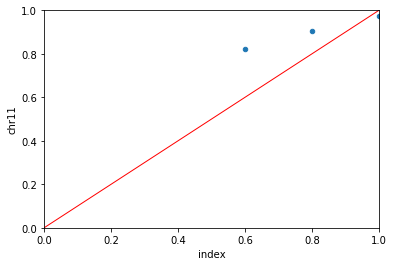

In [150]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[11::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

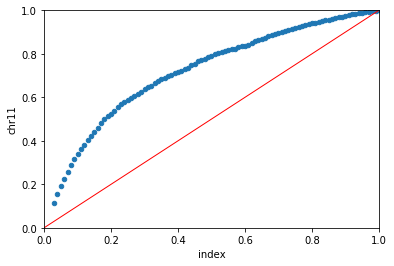

In [258]:
for thresh in df_plot.index.tolist():
    axes = df_plot.T.reset_index()[11::].plot.scatter(x='index', y=thresh)
    #axes = zt.reset_index().plot.scatter(x='x_p', y=0, s=1)
    #axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #axes = df_plot.T.reset_index().plot(x='index', y=0.3)
    axes.plot([0, 1], [0, 1], 'red', linewidth=1)
    #bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
    #axes.set_title('Predicting structure similarity from expression')
    #axes.yaxis.grid(True)
    #axes.set_xlabel('Co-expression')
    #axes.set_ylabel('AUC')
    #axes.set_ylim([0.0,1.101])
    #plt.setp(bp['fliers'], markersize=3.0)
    #0.5
    #fig, axes = plt.subplots()
    #axes.scatter(x, y)
    #axes.plot(x, y)
    axes.set_ylim([0,1])
    axes.set_xlim([0,1])

    #plt.show()
    plt.show()

In [154]:
df_scores_plot

chrm  num_pairs  dist_thresh       auc  \
0     chr11       1004          2.0  0.603357   
1     chr11       1004          1.0  0.950000   
2     chr11       1004          1.0  0.990826   
3     chr11       1004          2.0  0.964930   
4     chr11       1004          5.0  0.937400   
...     ...        ...          ...       ...   
999   chr11       1004          2.0  0.074297   
1000  chr11       1004          6.0  0.426445   
1001  chr11       1004          6.0  0.650485   
1002  chr11       1004          6.0  0.793478   
1003  chr11       1004          6.0  0.855932   

                                               pr_curve  true_pos  true_neg  \
0     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       566         2   
1     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       480         1   
2     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       436         1   
3     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       499         2   
4     {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       623         2   
...                                                 ...       ...       ...   
999   {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       498         1   
1000  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       571         2   
1001  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       618         1   
1002  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       552         3   
1003  {0.0: 1.0, 0.01: 1.0, 0.02: 1.0, 0.03: 1.0, 0....       472         1   

      exp_median  exp_mean   exp_var  ... 0.82  0.83  0.85  0.86  0.88  0.89  \
0       0.818331  0.709948  0.077252  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1       0.711796  0.638367  0.072380  ...  NaN   NaN   NaN   NaN   NaN   NaN   
2       0.680995  0.613632  0.075320  ...  NaN   NaN   NaN   NaN   NaN   NaN   
3       0.690213  0.630627  0.070869  ...  NaN   NaN   NaN   NaN   NaN   NaN   
4       0.712888  0.625489  0.079132  ...  NaN   NaN   NaN   NaN   NaN   NaN   
...          ...       ...       ...  ...  ...   ...   ...   ...   ...   ...   
999     0.061497  0.109356  0.028743  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1000    0.264574  0.274264  0.040111  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1001    0.480949  0.495839  0.064536  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1002    0.684659  0.632675  0.075314  ...  NaN   NaN   NaN   NaN   NaN   NaN   
1003    0.745523  0.660855  0.078882  ...  NaN   NaN   NaN   NaN   NaN   NaN   

      0.9  0.91  0.92       1.0  
0     NaN   NaN   NaN  0.863074  
1     NaN   NaN   NaN  0.975000  
2     NaN   NaN   NaN  0.995413  
3     NaN   NaN   NaN  0.994990  
4     NaN   NaN   NaN  0.981541  
...   ...   ...   ...       ...  
999   NaN   NaN   NaN  0.537149  
1000  NaN   NaN   NaN  0.834501  
1001  NaN   NaN   NaN  0.825243  
1002  NaN   NaN   NaN  0.987319  
1003  NaN   NaN   NaN  0.927966  

[1004 rows x 66 columns]

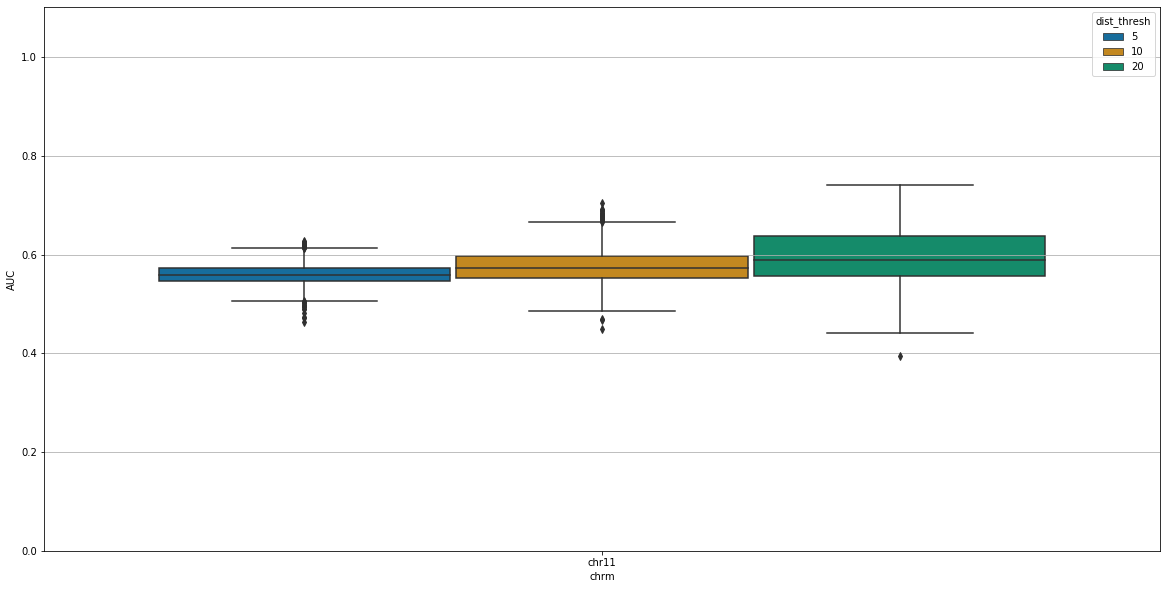

In [375]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20,10))
#grouped = df_scores.groupby(['threshold'])

#bp = grouped.boxplot(subplots=False, sym='k+', figsize=(8,10))
#bp = df_scores.boxplot(column=['auc'], by=['chrm', 'dist_thresh'], ax=axes,rot=40, fontsize=8,layout=(2, 1))
sns.boxplot(y='auc', x='chrm', 
                 data=df_scores, 
                 palette="colorblind",
                 hue='dist_thresh'
           )
#bp = axes.boxplot([[x if x>=0 else -1 for x in top_500_score_auroc_0_9], [x if x>=0 else -1 for x in top_500_score_auroc_0_7], [x if x>=0 else -1 for x in top_500_score_auroc_0_5], [x if x>=0 else -1 for x in top_500_score_auroc_0_4]] , sym='k+')
#axes.set_title('Predicting structure similarity from expression')
axes.yaxis.grid(True)
#axes.set_xlabel('Co-expression')
axes.set_ylabel('AUC')
axes.set_ylim([0.0,1.101])
#plt.setp(bp['fliers'], markersize=3.0)

plt.show()